In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

## Default Training

In [12]:
# Defining Kyoto Params and RL Params

tau_0 = 0.720
kappa = 10.07
chi = 0.92 * 2. * jnp.pi
kerr = 0.002
n0 = 25.5
res_amp_scaling = 1/0.51
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
actual_max_photons = 25.5
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 0.6
gamma_I = 1/286
photon_gamma = 1/1200
init_fid = 1.

time_coeff = 10.0
snr_coeff = 20.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 0.5
apply_smoothing = True
use_processed_action = True
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
apply_bandwidth_constraint = False
num_t1 = 6.0
photon_weight = 8.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 4000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 25.5
Actual Max Photons: 25.5


In [13]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

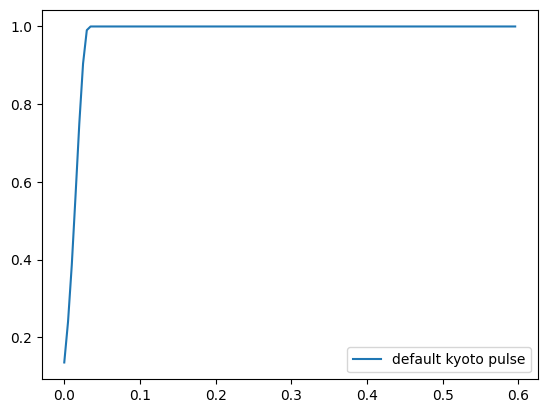

In [14]:
# Default Kyoto Action

ts = env.ts_action

gauss_sigma = 0.016
num_sigma = 2.
total_duration = 0.720

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default kyoto pulse')
plt.legend()
plt.show()

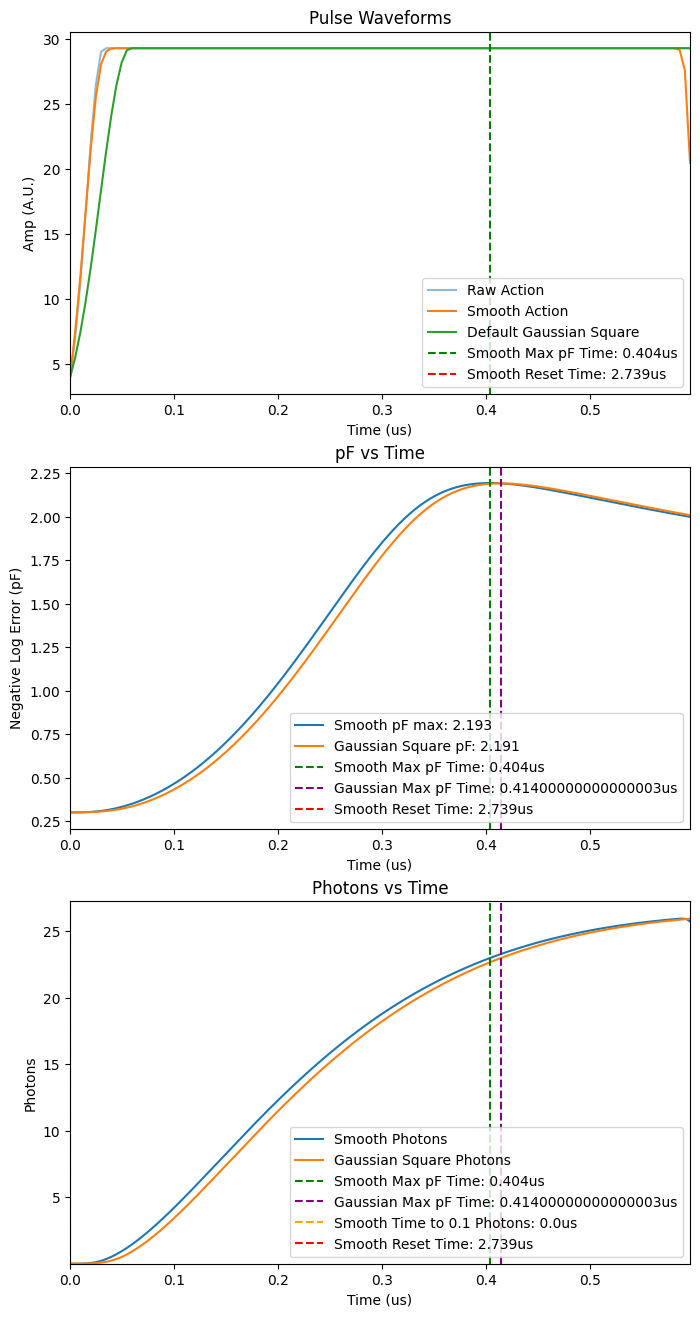

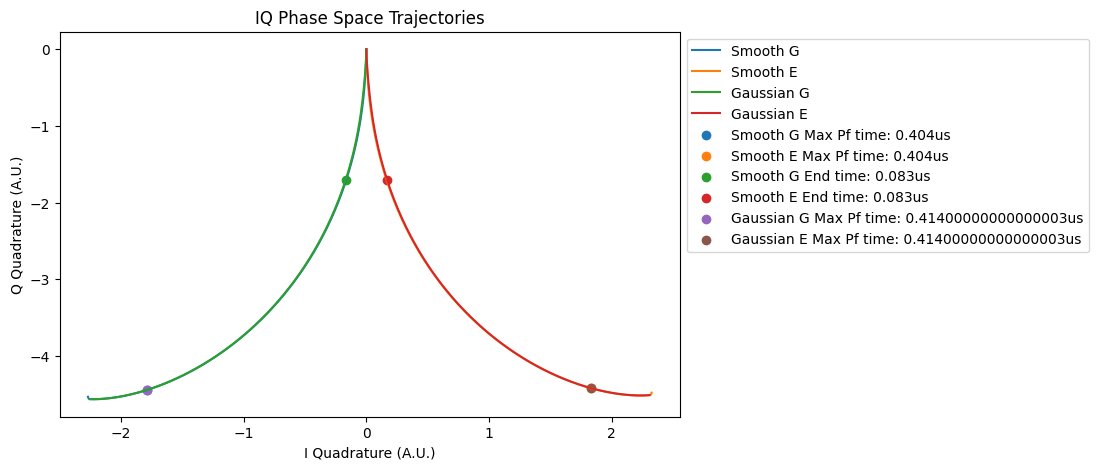

In [15]:
env.rollout_action(_rng, default_pulse)

## Starting Training

In [16]:
single_train = jit(PPO_Clipped_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -87.396
max pF: 2.172
max photon: 24.954
photon time: 1.225
smoothness: 0.012447
bandwidth: 28.12
global update: 200
reward: -25.536
max pF: 2.174
max photon: 25.585
photon time: 1.0397
smoothness: 0.006239
bandwidth: 17.217
global update: 300
reward: 11.790000000000001
max pF: 2.18
max photon: 25.506
photon time: 0.6996
smoothness: 0.0032679999999999996
bandwidth: 14.902000000000001
global update: 400
reward: 18.503
max pF: 2.179
max photon: 25.334
photon time: 0.5837
smoothness: 0.002721
bandwidth: 14.031
global update: 500
reward: 24.725
max pF: 2.183
max photon: 25.287
photon time: 0.5626
smoothness: 0.002281
bandwidth: 13.433
global update: 600
reward: 28.292
max pF: 2.185
max photon: 25.279
photon time: 0.5375
smoothness: 0.001982
bandwidth: 13.316
global update: 700
reward: 30.737000000000002
max pF: 2.185
max photon: 25.263
photon time: 0.5355
smoothness: 0.001774
bandwidth: 13.316
global update: 800
reward: 32.258
max p

In [17]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]

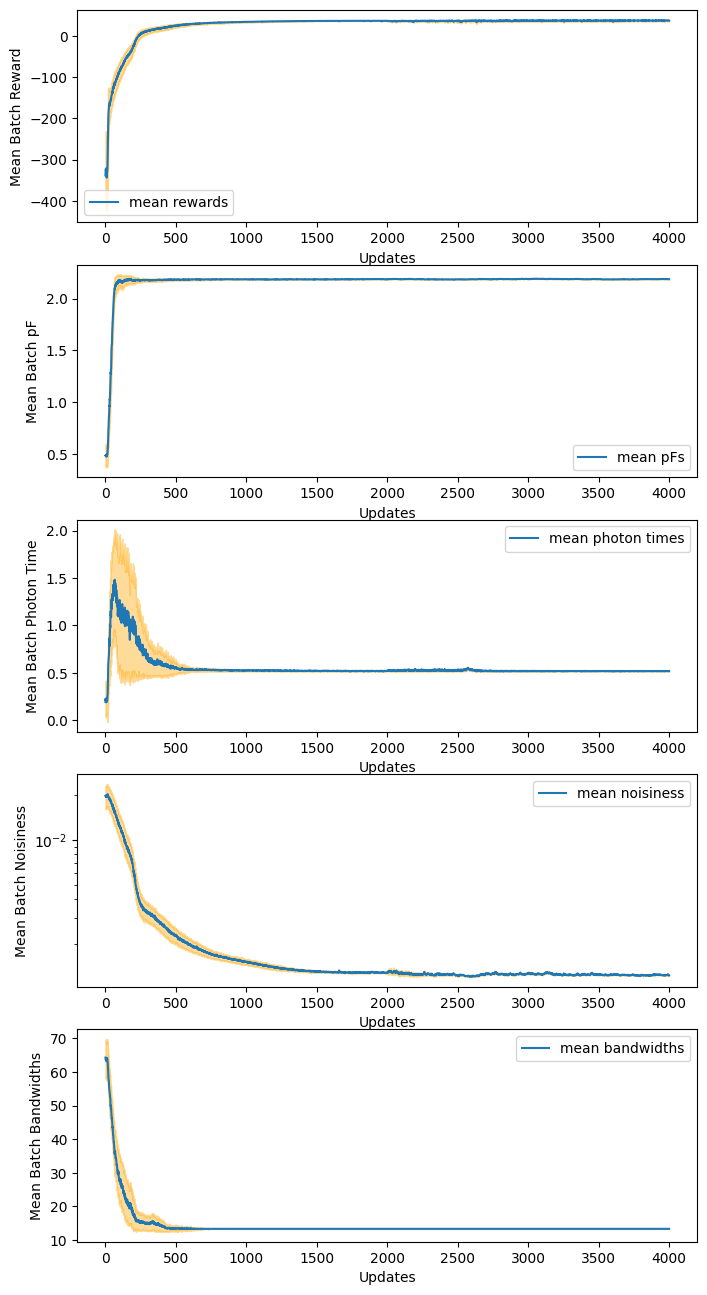

In [18]:
from utils import plot_learning

plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=bandwidths,
)

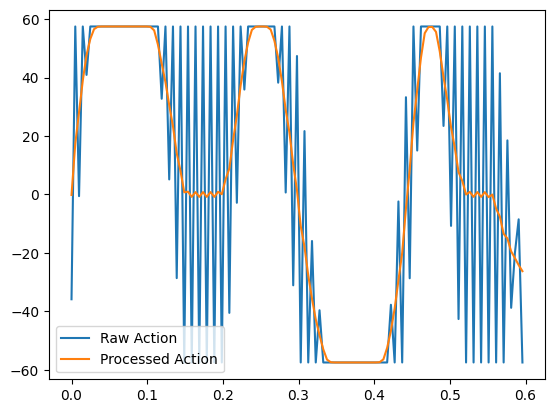

In [20]:
final_action = actions[-1, 0]
final_processed_action = env.prepare_action(final_action)

plt.plot(env.ts_action, final_action * env.a0, label='Raw Action')
plt.plot(env.ts_action, final_processed_action, label='Processed Action')
plt.legend()
plt.show()

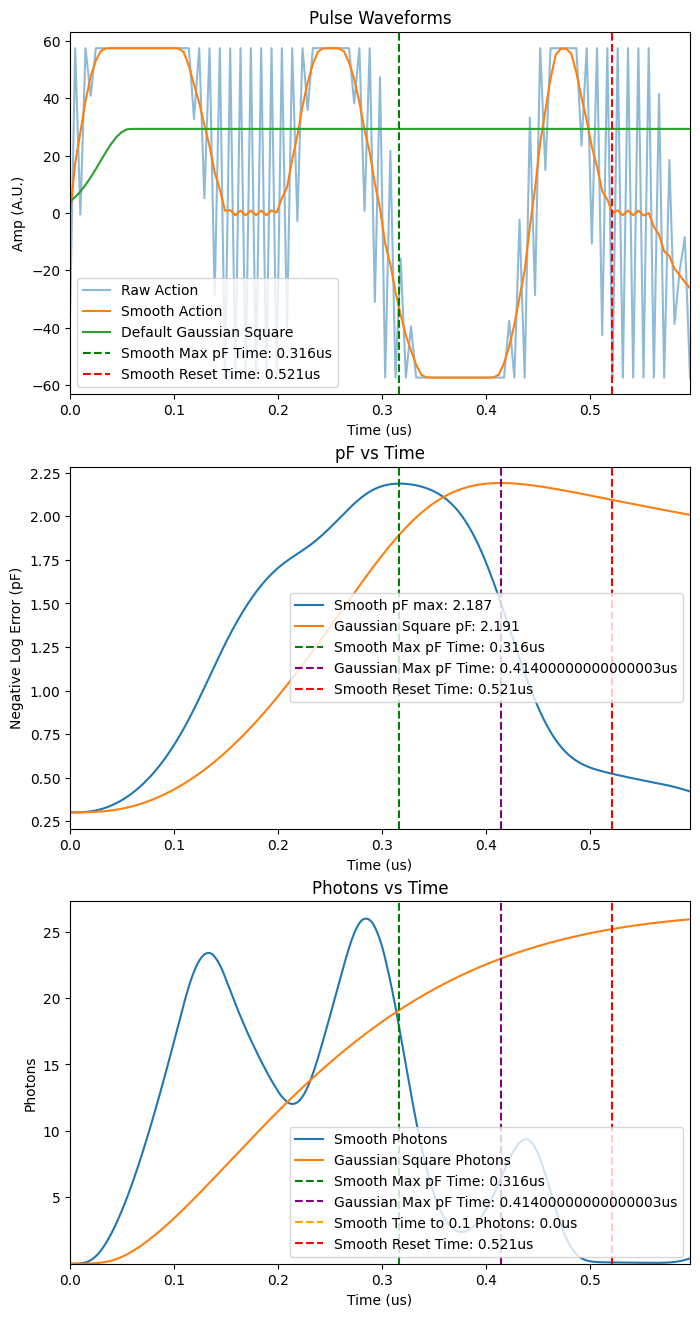

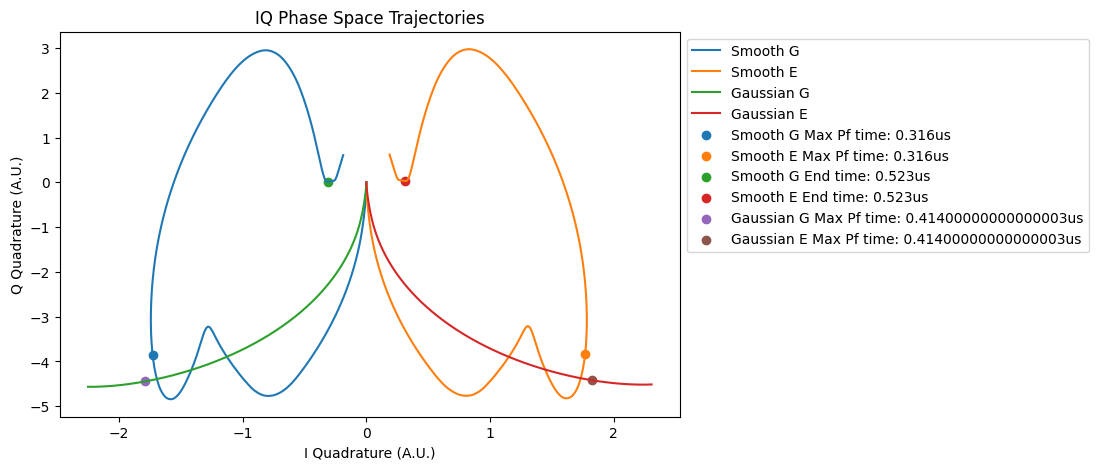

In [22]:
env.rollout_action(_rng, final_action, photon_log_scale=False)

## Training on the Processed Action directly

In [60]:
import copy

config_2 = copy.deepcopy(config)
config_2["ENV_PARAMS"]["use_processed_action"] = True
config_2["ENV_PARAMS"]["smoothness_baseline_scale"] = 0.1

config_2

{'LR': 0.0003,
 'NUM_ENVS': 256,
 'NUM_STEPS': 1,
 'NUM_UPDATES': 4000,
 'UPDATE_EPOCHS': 4,
 'NUM_MINIBATCHES': 4,
 'CLIP_EPS': 0.2,
 'VALUE_CLIP_EPS': 0.2,
 'ENT_COEF': 0.0,
 'VF_COEF': 0.5,
 'MAX_GRAD_NORM': 0.5,
 'ACTIVATION': 'relu6',
 'LAYER_SIZE': 128,
 'ENV_NAME': 'single_langevin_env',
 'ENV_PARAMS': {'kappa': 10.07,
  'chi': 5.7805304826052195,
  'kerr': 0.002,
  'time_coeff': 10.0,
  'snr_coeff': 10.0,
  'smoothness_coeff': 10.0,
  'smoothness_baseline_scale': 0.1,
  'apply_smoothing': True,
  'use_processed_action': True,
  'bandwidth': 50.0,
  'freq_relative_cutoff': 0.1,
  'bandwidth_coeff': 100.0,
  'apply_bandwidth_constraint': False,
  'n0': 25.5,
  'tau_0': 0.72,
  'res_amp_scaling': 1.9607843137254901,
  'nR': 0.01,
  'snr_scale_factor': 0.6,
  'gamma_I': 0.0034965034965034965,
  'photon_gamma': 0.0008333333333333334,
  'num_t1': 6.0,
  'init_fid': 1.0,
  'photon_weight': 4.0,
  'standard_fid': 0.99,
  'shot_noise_std': 0.0},
 'ANNEAL_LR': False,
 'DEBUG': True,
 'DE

In [61]:
single_train_2 = jit(PPO_Clipped_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -600.828
max pF: 2.09
max photon: 25.072
photon time: 1.7055
smoothness: 0.013814
bandwidth: 34.96
global update: 200
reward: -288.946
max pF: 2.198
max photon: 27.588
photon time: 1.0278
smoothness: 0.006729
bandwidth: 17.152
global update: 300
reward: -148.81300000000002
max pF: 2.17
max photon: 25.776
photon time: 1.6759000000000002
smoothness: 0.0035499999999999998
bandwidth: 15.201
global update: 400
reward: -113.262
max pF: 2.166
max photon: 25.718
photon time: 1.7827000000000002
smoothness: 0.002721
bandwidth: 14.109
global update: 500
reward: -94.07600000000001
max pF: 2.172
max photon: 25.574
photon time: 1.7338
smoothness: 0.002289
bandwidth: 14.148
global update: 600
reward: -82.227
max pF: 2.172
max photon: 25.078
photon time: 1.7006000000000001
smoothness: 0.0020499999999999997
bandwidth: 13.381
global update: 700
reward: -70.994
max pF: 2.176
max photon: 25.007
photon time: 1.7144000000000001
smoothness: 0.001792
b

In [62]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
bandwidths_2 = metrics_2["bandwidth"]
actions_2 = metrics_2["action"]

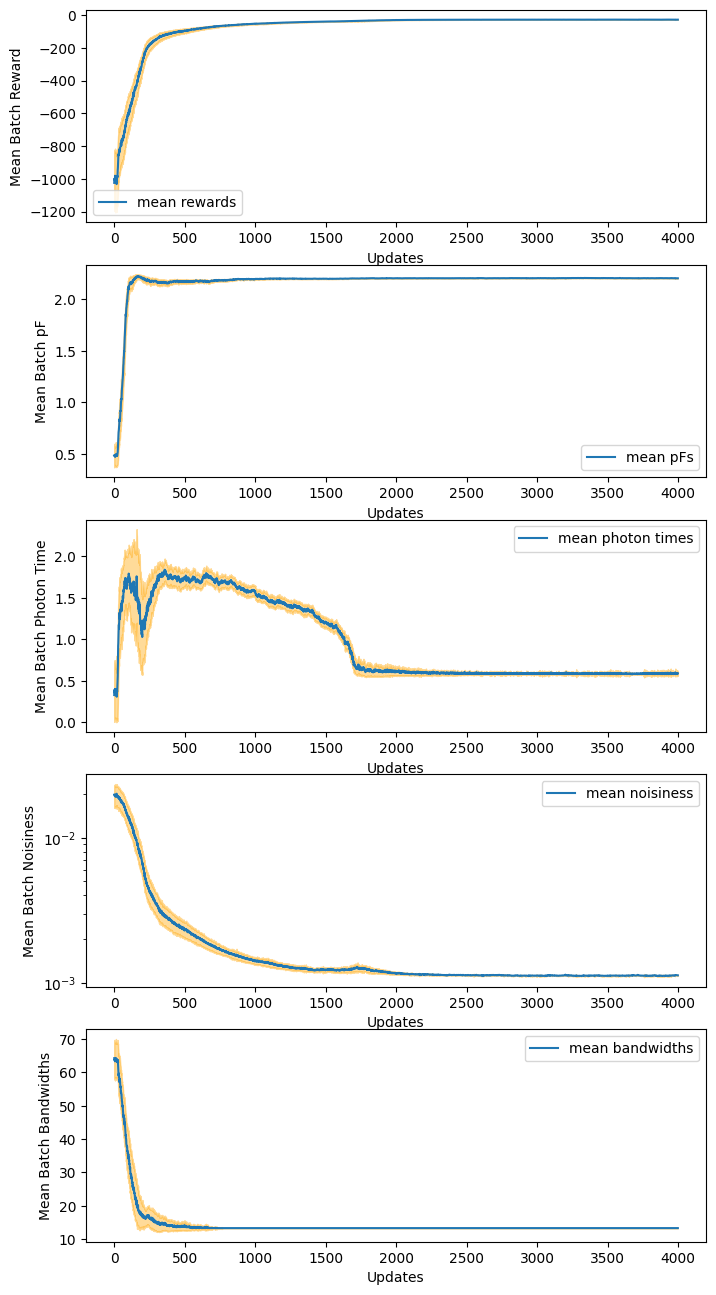

In [63]:
plot_learning(
    rewards=rewards_2,
    max_pFs=max_pFs_2,
    photon_times=photon_times_2,
    smoothnesses=smoothnesses_2,
    bandwidths=bandwidths_2,
)

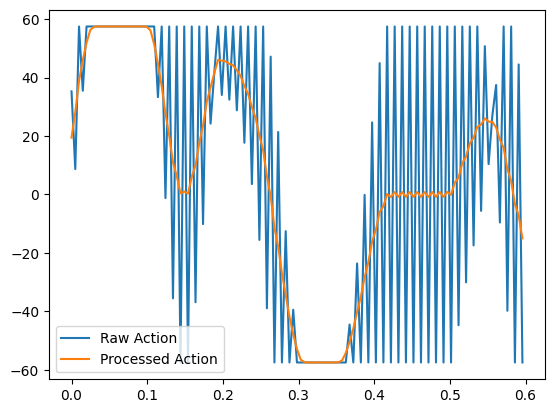

In [64]:
final_action_2 = actions_2[-1, 0]
final_processed_action_2 = env.prepare_action(final_action_2)

plt.plot(env.ts_action, final_action_2 * env.a0, label='Raw Action')
plt.plot(env.ts_action, final_processed_action_2, label='Processed Action')
plt.legend()
plt.show()

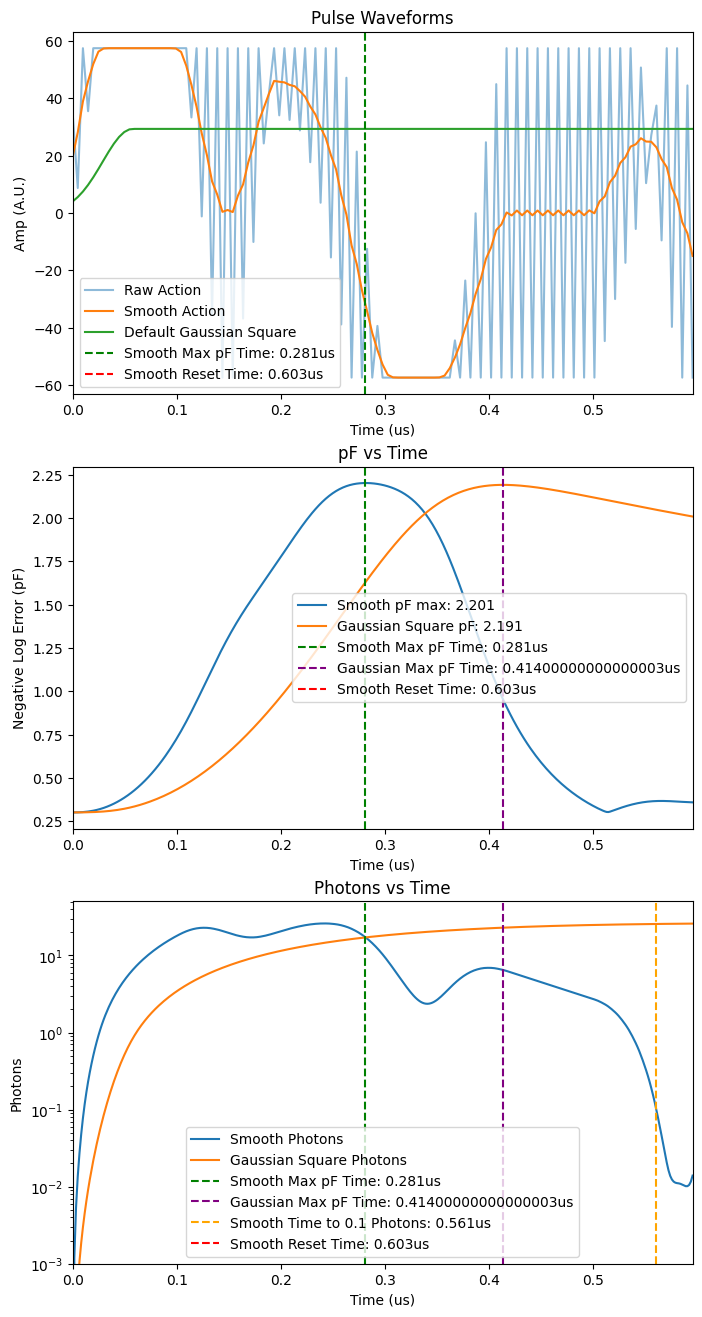

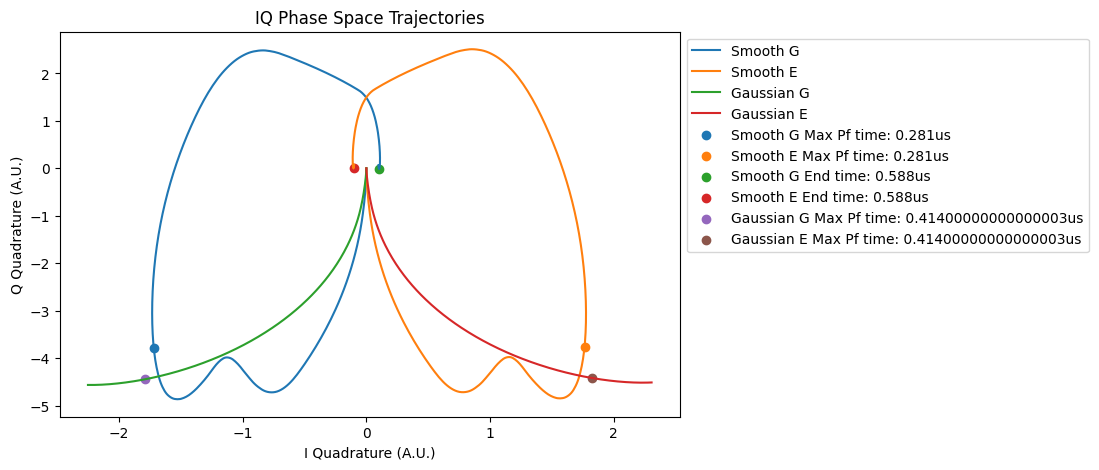

In [65]:
env.rollout_action(_rng, final_action_2, photon_log_scale=True)